# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры.  Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.


# 1. Подготовка данных

In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

df = pd.read_csv('Churn.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [2]:
df['Tenure'].corr(df['Exited'])


-0.016761481514933847

В этом столбце (Tenure) много пропусков, но он крайне мало коррелирует с целевым признаком. Чтобы не удалять большое количество строк с признаками, которые могут иметь значение, и не заполнять пропуски медианой, меткой и т.п. (а смысл, если признак не влияет?) я удалю столбец целиком.

In [3]:
df = df.drop('Tenure', axis = 1)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,125510.82,1,1,1,79084.10,0


# 2. Исследование задачи

In [4]:
class_frequency = df['Exited'].value_counts(normalize=True)
print(class_frequency)

0    0.7963
1    0.2037
Name: Exited, dtype: float64


Приблизительно каждый четвертый клиент из данной выборки ушёл из банка.

In [5]:
df_to_encoder = df[['Geography', 'Gender']]
df_no_encoder = df.drop(['Surname', 'Geography', 'Gender'], axis=1)

df_to_encoder = pd.get_dummies(df_to_encoder , drop_first=True)
df_ordinal = df_to_encoder.join(df_no_encoder)
df_ordinal

,Geography_Germany,Geography_Spain,Gender_Male,RowNumber,CustomerId,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,0,0,1,15634602,619,42,0.00,1,1,1,101348.88,1
1,0,1,0,2,15647311,608,41,83807.86,1,0,1,112542.58,0
2,0,0,0,3,15619304,502,42,159660.80,3,1,0,113931.57,1
3,0,0,0,4,15701354,699,39,0.00,2,0,0,93826.63,0
4,0,1,0,5,15737888,850,43,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,1,9996,15606229,771,39,0.00,2,1,0,96270.64,0
9996,0,0,1,9997,15569892,516,35,57369.61,1,1,1,101699.77,0
9997,0,0,0,9998,15584532,709,36,0.00,1,0,1,42085.58,1
9998,1,0,1,9999,15682355,772,42,75075.31,2,1,0,92888.52,1


Закодировала столбцы, имеющие строковые значения - страны, пол. Столбец с фамилиями я исключила из датасета, мне кажется логичным, что фамилия не может быть признаком причины ухода из банка. Кроме того, забегая вперёд, я удалила фамилию уже после устранения дисбаланса в ходе эксперимента, и значение F1 от этого увеличилось :).

In [6]:
#разбиваем датасет
target = df_ordinal['Exited']
features = df_ordinal.drop('Exited', axis=1)
features_other, features_test, target_other, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
   features_other, target_other, test_size=0.25, random_state=12345)

print('features_train', len(features_train))
print('features_valid', len(features_valid))
print('features_test', len(features_test))

features_train 6000
features_valid 2000
features_test 2000


Данные разбиты корректно.

In [7]:
#исследуем дерево
tree_result = pd.DataFrame(columns = ['depth', 'accuracy_train', 'accuracy_valid'])
i= 0

for depth in range(1, 21, 1):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model_tree.fit(features_train, target_train)
    predictions_tree_train = model_tree.predict(features_train)
    predictions_tree_valid = model_tree.predict(features_valid)
    accuracy_tree_train = accuracy_score(target_train, predictions_tree_train)
    accuracy_tree_valid = accuracy_score(target_valid, predictions_tree_valid)
    tree_result.loc[i, 'depth'] = depth
    tree_result.loc[i, 'accuracy_train'] = accuracy_tree_train
    tree_result.loc[i, 'accuracy_valid'] = accuracy_tree_valid
    i +=1
    
tree_result

,depth,accuracy_train,accuracy_valid
0,1,0.796833,0.8045
1,2,0.830667,0.8325
2,3,0.843333,0.843
3,4,0.850167,0.8485
4,5,0.859833,0.8545
5,6,0.867667,0.86
6,7,0.8765,0.8575
7,8,0.890333,0.852
8,9,0.9045,0.842
9,10,0.915667,0.841


In [8]:
#исследуем лес
forest_result = pd.DataFrame(columns = ['estim', 'depth', 'accuracy_train', 'accuracy_valid'])
i= 0
for estim in range(5, 51, 5):
    for depth in range(2, 11, 2):
        model_forest = RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=12345)
        model_forest.fit(features_train, target_train)
        predictions_forest_train = model_forest.predict(features_train)
        predictions_forest_valid = model_forest.predict(features_valid)
        accuracy_forest_train = accuracy_score(target_train, predictions_forest_train)
        accuracy_forest_valid = accuracy_score(target_valid, predictions_forest_valid)
        forest_result.loc[i, 'estim'] = estim
        forest_result.loc[i, 'depth'] = depth
        forest_result.loc[i, 'accuracy_train'] = accuracy_forest_train
        forest_result.loc[i, 'accuracy_valid'] = accuracy_forest_valid
        i +=1
    
forest_result   

,estim,depth,accuracy_train,accuracy_valid
0,5,2,0.820833,0.828
1,5,4,0.842333,0.839
2,5,6,0.8595,0.8505
3,5,8,0.877833,0.8555
4,5,10,0.9,0.8545
5,10,2,0.821,0.828
6,10,4,0.843333,0.8395
7,10,6,0.861333,0.852
8,10,8,0.881333,0.8585
9,10,10,0.9,0.8585


In [9]:
#исследуем логистическую регрессию
model_log = LogisticRegression(random_state=12345)
model_log.fit(features_train, target_train)
predictions_log_train = model_log.predict(features_train)
predictions_log_valid = model_log.predict(features_valid)
accuracy_log_train = accuracy_score(target_train, predictions_log_train)
accuracy_log_valid = accuracy_score(target_valid, predictions_log_valid)
print('Качество логистической регрессии на обучающей выборке:', accuracy_log_train )
print('Качество логистической регрессии на валидационной выборке:', accuracy_log_valid )

Качество логистической регрессии на обучающей выборке: 0.7968333333333333
Качество логистической регрессии на валидационной выборке: 0.8045


C:\Users\Tehnodent\DS\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
print('Максимальное значение качества модели "Дерево" на валидационной выборке:', tree_result['accuracy_valid'].max())
print('Максимальное значение качества модели "Лес" на валидационной выборке:', forest_result['accuracy_valid'].max())
print('Значение качества логистической модели на валидационной выборке:', accuracy_log_valid)

Максимальное значение качества модели "Дерево" на валидационной выборке: 0.86
Максимальное значение качества модели "Лес" на валидационной выборке: 0.865
Значение качества логистической модели на валидационной выборке: 0.8045


In [11]:
#находим индекс строки с максимальным значением, чтобы задать такие же гиперпараметры
max_accuracy = forest_result['accuracy_valid'].max()
print(forest_result.query('accuracy_valid == @max_accuracy').index)

Int64Index([19], dtype='int64')


In [12]:
model = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=12345)
model.fit(features_train, target_train)
predictions= model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions)
print('Качество модели на тестовой выборке:',accuracy)
print('Матрица ошибок:', confusion_matrix(target_valid, predictions))
print('Полнота:',recall_score(target_valid, predictions))
print('Точность:',precision_score(target_valid, predictions))
print('F1 :', f1_score(target_valid, predictions))


Качество модели на тестовой выборке: 0.865
Матрица ошибок: [[1561   48]
 [ 222  169]]
Полнота: 0.4322250639386189
Точность: 0.7788018433179723
F1 : 0.555921052631579


Полнота низкая, хоть и точость неплохая. Теперь поборемся за баланс.

# 3. Борьба с дисбалансом

In [13]:
#зададим классам веса
model_t = DecisionTreeClassifier(max_depth=5, random_state=12345, class_weight='balanced')
model_t.fit(features_train, target_train)
predictions= model_t.predict(features_valid)
print("F1 tree:", f1_score(target_valid, predictions))

model_l = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_l.fit(features_train, target_train)
predictions= model_l.predict(features_valid)
print("F1 LogisticRegression:", f1_score(target_valid, predictions))

model_f1 = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=12345, class_weight='balanced')
model_f1.fit(features_train, target_train)
predictions= model_f1.predict(features_valid)
f1_f1 = f1_score(target_valid, predictions)
print("F1 forest:", f1_f1)


F1 tree: 0.5515267175572519
F1 LogisticRegression: 0.46511627906976744
F1 forest: 0.5743329097839899


Лес всё так же лучший. Думаю, рассматривать дерево и логистическую регрессию дальше смысла нет с таким отрывом. F1 уже выше, было ведь 0.55. Посмотрим на другие метрики леса:

In [14]:
total_result = pd.DataFrame(columns = ['Модель', 'F1', 'Качество', 'Полнота', 'Точность'])

accuracy_f1 = accuracy_score(target_valid, predictions)
recall_f1 = recall_score(target_valid, predictions)
precision_f1 =  precision_score(target_valid, predictions)
print('Матрица ошибок:', confusion_matrix(target_valid, predictions))

#list = ['model_f1', f1_f1, accuracy_f1, recall_f1, precision_f1]
total_result.loc[0] = ['model_f1', f1_f1, accuracy_f1, recall_f1, precision_f1]
total_result


Матрица ошибок: [[1439  170]
 [ 165  226]]


,Модель,F1,Качество,Полнота,Точность
0,model_f1,0.574333,0.8325,0.578005,0.570707


In [15]:
#увеличим выборку - добавим больше признаков объектов с ответом «1»
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

#обучим три разные модели на увеличенной выборке. Подберем наилучшее значение F1 при разных значениях repeat
    
result_upsample = pd.DataFrame(columns = ['repeat','F1'])
i = 0
for repeat in range(2,21,1):
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)

    result_upsample.loc[i, 'repeat'] = repeat

    model_f = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=12345, class_weight='balanced')
    model_f.fit(features_upsampled, target_upsampled)
    predictions= model_f.predict(features_valid)
    result_upsample.loc[i, 'F1'] = f1_score(target_valid, predictions)

    i +=1
    
result_upsample    

,repeat,F1
0,2,0.569412
1,3,0.586881
2,4,0.595696
3,5,0.581006
4,6,0.590389
5,7,0.597961
6,8,0.583333
7,9,0.574011
8,10,0.583524
9,11,0.576617


F1 стал немного больше, чем до увеличения выборки. Хочу посмотерть на другие метрики при repeat = 2, который дал нам макимальную f1:

In [16]:
max= result_upsample['F1'].max()
print(result_upsample.query('F1 == @max').index)

Int64Index([5], dtype='int64')


In [17]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 7)
model_f2 = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=12345, class_weight='balanced')
model_f2.fit(features_upsampled, target_upsampled)
predictions= model_f2.predict(features_valid)

f1_f2 = f1_score(target_valid, predictions)
accuracy_f2 = accuracy_score(target_valid, predictions)
recall_f2 = recall_score(target_valid, predictions)
precision_f2 =  precision_score(target_valid, predictions)
print('Матрица ошибок:', confusion_matrix(target_valid, predictions))

total_result.loc[1] = ['model_f2', f1_f2, accuracy_f2, recall_f2, precision_f2]
total_result

Матрица ошибок: [[1381  228]
 [ 127  264]]


,Модель,F1,Качество,Полнота,Точность
0,model_f1,0.574333,0.8325,0.578005,0.570707
1,model_f2,0.597961,0.8225,0.675192,0.536585


Метрики изменились - полнота и f1 стали выше. 

In [18]:
# попробуем подобрать пороговое значение
probabilities_valid= model_f2.predict_proba(features_valid)
probabilities_one_valid= probabilities_valid[:, 1]

for threshold in np.arange(0, 1.0, 0.05):
    predicted_valid= probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.196, Полнота = 1.000, F1 = 0.327
Порог = 0.05 | Точность = 0.199, Полнота = 0.995, F1 = 0.332
Порог = 0.10 | Точность = 0.223, Полнота = 0.985, F1 = 0.363
Порог = 0.15 | Точность = 0.249, Полнота = 0.974, F1 = 0.397
Порог = 0.20 | Точность = 0.280, Полнота = 0.944, F1 = 0.432
Порог = 0.25 | Точность = 0.314, Полнота = 0.921, F1 = 0.468
Порог = 0.30 | Точность = 0.349, Полнота = 0.870, F1 = 0.498
Порог = 0.35 | Точность = 0.388, Полнота = 0.826, F1 = 0.528
Порог = 0.40 | Точность = 0.428, Полнота = 0.777, F1 = 0.552
Порог = 0.45 | Точность = 0.473, Полнота = 0.716, F1 = 0.570
Порог = 0.50 | Точность = 0.537, Полнота = 0.675, F1 = 0.598
Порог = 0.55 | Точность = 0.578, Полнота = 0.614, F1 = 0.596
Порог = 0.60 | Точность = 0.618, Полнота = 0.537, F1 = 0.575
Порог = 0.65 | Точность = 0.666, Полнота = 0.499, F1 = 0.570
Порог = 0.70 | Точность = 0.717, Полнота = 0.440, F1 = 0.545
Порог = 0.75 | Точность = 0.777, Полнота = 0.384, F1 = 0.514
Порог = 0.80 | Точность 

In [20]:
model_f3 = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=12345, class_weight={1:0.5, 0:0.5})
model_f3.fit(features_upsampled, target_upsampled)
predictions= model_f3.predict(features_valid)
f1_f3 = f1_score(target_valid, predictions)
accuracy_f3 = accuracy_score(target_valid, predictions)
recall_f3 = recall_score(target_valid, predictions)
precision_f3 =  precision_score(target_valid, predictions)
print('Матрица ошибок:', confusion_matrix(target_valid, predictions))

total_result.loc[3] = ['model_f3', f1_f3, accuracy_f3, recall_f3, precision_f3]
total_result

Матрица ошибок: [[1219  390]
 [  95  296]]


,Модель,F1,Качество,Полнота,Точность
0,model_f1,0.574333,0.8325,0.578005,0.570707
1,model_f2,0.597961,0.8225,0.675192,0.536585
3,model_f3,0.549675,0.7575,0.757033,0.431487


# 4. Тестирование модели

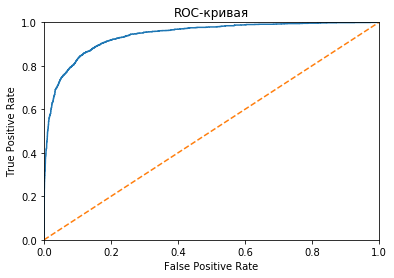

In [22]:
#построим ROC-кривую и посчитаем auc_roc по тренировочной и валидационной выборке вместе

import matplotlib.pyplot as plt
probabilities_other = model_f3.predict_proba(features_other)
probabilities_one_other = probabilities_other[:, 1]
fpr, tpr, thresholds = roc_curve(target_other, probabilities_one_other)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


In [23]:
auc_roc = roc_auc_score(target_other, probabilities_one_other)
auc_roc

0.9411196648489973

Судя по графику и значению auc_roc,близкому к 1, наша модель очень даже неплоха. Проверим лучшую, третью модель на тестовой выборке:

In [24]:
features_upsampled, target_upsampled = upsample(features_other, target_other, 7)


model_f3.fit(features_upsampled, target_upsampled)
predictions= model_f3.predict(features_test)
f1_f4 = f1_score(target_test, predictions)
accuracy_f4 = accuracy_score(target_test, predictions)
recall_f4 = recall_score(target_test, predictions)
precision_f4 =  precision_score(target_test, predictions)
print('Матрица ошибок:', confusion_matrix(target_test, predictions))

total_result.loc[4] = ['model_final', f1_f4, accuracy_f4, recall_f4, precision_f4]
total_result

Матрица ошибок: [[1175  398]
 [  83  344]]


,Модель,F1,Качество,Полнота,Точность
0,model_f1,0.574333,0.8325,0.578005,0.570707
1,model_f2,0.597961,0.8225,0.675192,0.536585
3,model_f3,0.549675,0.7575,0.757033,0.431487
4,model_final,0.588537,0.7595,0.805621,0.463612


Итак, наш f1 равен 0.59. Модель показала себя на тесте лучше, чем во время обучения, и не переобучилась.